In [1]:
# Numeric Packages
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as sps

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

# Other
from datetime import datetime, timedelta
import statsmodels.api as sm

In [2]:
# Import turnstile data and convert datetime column to datetime python objects
df = pd.read_csv('turnstile_weather_v2.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
# Because the hour '0' is actually the entries from 20:00 to 24:00, it makes more sense to label it 24 when plotting data
df.datetime -= timedelta(seconds=1)
df['day']= df.datetime.apply(lambda x: x.day)
df['hour'] = df.datetime.apply(lambda x: x.hour+1)
df['weekday'] = df.datetime.apply(lambda x: not bool(x.weekday()//5))
df['day_week'] = df.datetime.apply(lambda x: x.weekday())
# df.loc[df['hour']==24, 'day'] -=1

In [4]:
# The dataset includes the Memorial Day Public Holiday, which should be classified as a weekend.
df.loc[df['day']==30,'weekday'] = False

In [5]:
# Filter out results from 30th April... they're just going to make things messy in the plots
plot_df = df[df.datetime.apply(lambda x: x.month==5)]

In [6]:
timelabels = ['Midnight - 4am','4am - 8am','8am - 12pm','12pm - 4pm','4pm - 8pm','8pm - Midnight']
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

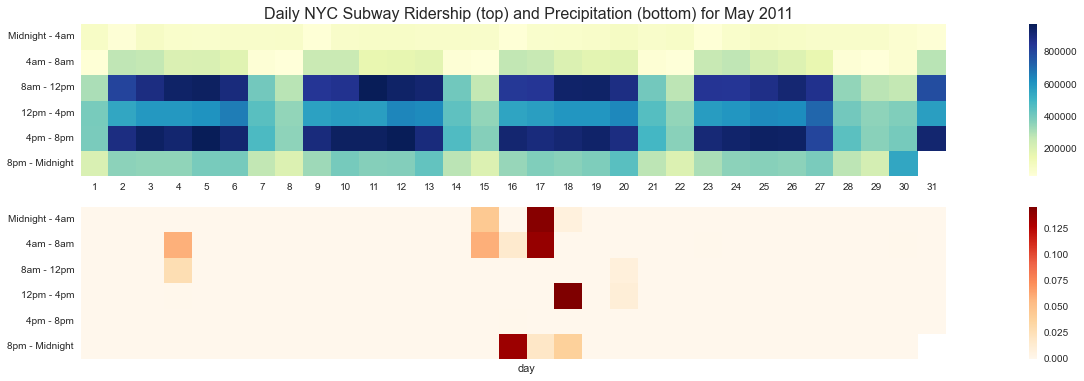

In [7]:
plt.figure(figsize=[20,6])

plt.subplot(211)
data=df.pivot_table(values='ENTRIESn_hourly',index='hour',columns='day', aggfunc=np.sum)
sns.heatmap(data, cmap='YlGnBu', yticklabels=timelabels)
plt.ylabel('')
plt.xlabel('')
plt.xlim(0,32)
plt.title('Daily NYC Subway Ridership (top) and Precipitation (bottom) for May 2011', fontsize=16)
# plt.show()


plt.subplot(212)
data=df.pivot_table(values='precipi',index='hour',columns='day', aggfunc=np.mean)
# plt.figure(figsize=[20,3])
sns.heatmap(data, cmap='OrRd', yticklabels=timelabels)
plt.ylabel('')
plt.xlim(0,32)
plt.xticks([])
# plt.title('Daily NYC Subway Ridership for May 2011', fontsize=16)
plt.show()

In [8]:
mydf = df[df.day!=30].pivot_table(values='ENTRIESn_hourly', index=['day','day_week','hour'], aggfunc=np.sum).reset_index()
mydf = mydf.pivot_table(values='ENTRIESn_hourly', index='hour', columns='day_week', aggfunc=np.mean)


sns.heatmap(mydf, yticklabels=timelabels, xticklabels=weekdays)
plt.xlabel('')
plt.ylabel('')
plt.title('Daily NYC Subway Ridership for May 2011', fontsize=14)
plt.show()

In [10]:
df.columns

Index([u'UNIT', u'DATEn', u'TIMEn', u'ENTRIESn', u'EXITSn', u'ENTRIESn_hourly',
       u'EXITSn_hourly', u'datetime', u'hour', u'day_week', u'weekday',
       u'station', u'latitude', u'longitude', u'conds', u'fog', u'precipi',
       u'pressurei', u'rain', u'tempi', u'wspdi', u'meanprecipi',
       u'meanpressurei', u'meantempi', u'meanwspdi', u'weather_lat',
       u'weather_lon', u'day'],
      dtype='object')

In [11]:
df['hour_str'] = [str(i) for i in df['hour']]
df['day_str'] = df.datetime.apply(lambda x: x.strftime('%A'))

In [60]:
mod = sm.OLS.from_formula('ENTRIESn_hourly ~ precipi + C(weekday) + UNIT + C(hour) -1', data=df)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     212.0
Date:                Sat, 01 Aug 2015   Prob (F-statistic):               0.00
Time:                        00:06:18   Log-Likelihood:            -3.8420e+05
No. Observations:               42649   AIC:                         7.689e+05
Df Residuals:                   42402   BIC:                         7.710e+05
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
C(weekday)[False] -2184.8212    155.03

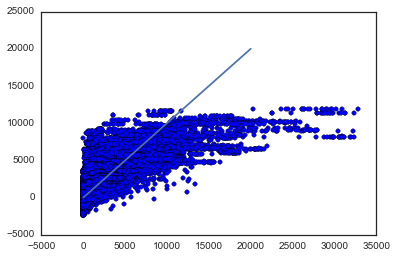

In [62]:
plt.plot([0,20000],[0,20000])
plt.scatter(df.ENTRIESn_hourly,res.predict())

In [14]:
mydf2 = df.pivot_table(values='ENTRIESn_hourly', index=['day','weekday','hour_str','precipi'], aggfunc=np.sum).reset_index()
mod = sm.OLS.from_formula('ENTRIESn_hourly ~ precipi + weekday + hour_str', data=mydf2)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     87.61
Date:                Fri, 31 Jul 2015   Prob (F-statistic):           1.37e-57
Time:                        14:56:33   Log-Likelihood:                -2796.4
No. Observations:                 209   AIC:                             5609.
Df Residuals:                     201   BIC:                             5635.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        5.247e+05   3.24e+04     

In [15]:
len(df)

42649

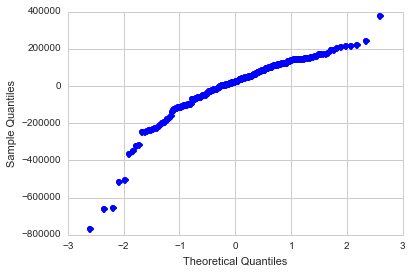

In [16]:
sm.qqplot((mydf2.ENTRIESn_hourly-res.predict()))
plt.show()

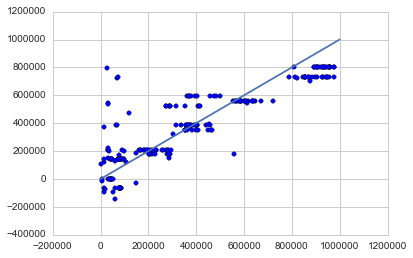

In [17]:
plt.plot([0,1000000],[0,1000000])
plt.scatter(mydf2.ENTRIESn_hourly,res.predict())

In [18]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like.

    http://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
    """

    slope, intercept, r_value, p_value, std_err = sps.linregress(x, y)
    return r_value**2

In [19]:
rsquared(df.ENTRIESn_hourly,res.predict())

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [20]:
plt.hist(df.ENTRIESn_hourly-res.predict(), bins=100)
plt.show()

ValueError: operands could not be broadcast together with shapes (42649,) (209,) 

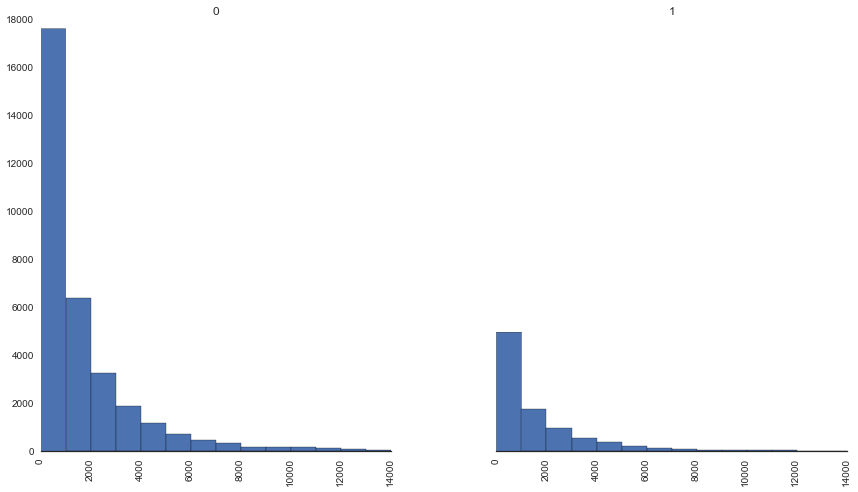

In [21]:
sns.set_style('white')
df.hist(column='ENTRIESn_hourly', by='rain', bins=np.arange(0,15000,1000), sharey=True, figsize=[14,8])
sns.despine(left=True)

In [23]:
df.columns

Index([u'UNIT', u'DATEn', u'TIMEn', u'ENTRIESn', u'EXITSn', u'ENTRIESn_hourly',
       u'EXITSn_hourly', u'datetime', u'hour', u'day_week', u'weekday',
       u'station', u'latitude', u'longitude', u'conds', u'fog', u'precipi',
       u'pressurei', u'rain', u'tempi', u'wspdi', u'meanprecipi',
       u'meanpressurei', u'meantempi', u'meanwspdi', u'weather_lat',
       u'weather_lon', u'day', u'hour_str', u'day_str'],
      dtype='object')

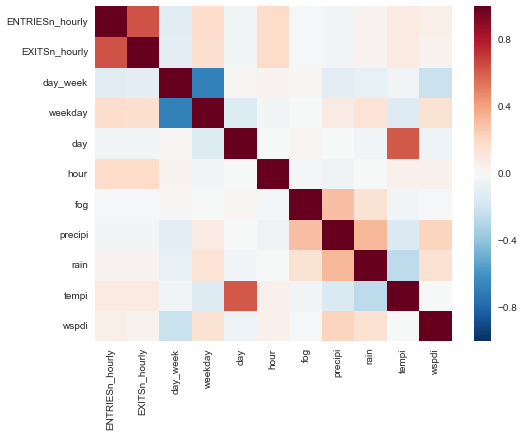

In [36]:
plt.figure(figsize=[8,6])
sns.heatmap(
    df[['ENTRIESn_hourly','EXITSn_hourly','day_week','weekday','day','hour','fog','precipi','rain','tempi','wspdi']].corr(),
    )

In [50]:
import matplotlib as mpl

In [51]:
plt.scatter(mpl.dates.date2num(df.datetime), df.tempi)

AttributeError: 'numpy.datetime64' object has no attribute 'toordinal'

(0, 35000.0)

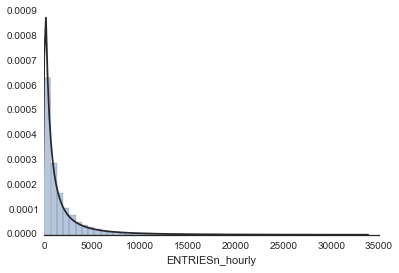

In [22]:

sns.distplot(df.ENTRIESn_hourly, kde=False, fit=sps.lognorm)
sns.despine(left=True)
plt.xlim(xmin=0)

In [ ]:
df.columns

In [ ]:
sns.pairplot(df[[')

KeyboardInterrupt: 

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 388, in execute_request
    self._abort_queues()
  File "/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py", line 588, in _abort_queues
    self._abort_queue(stream)
  File "/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.p

(734258.0, 734272.0)

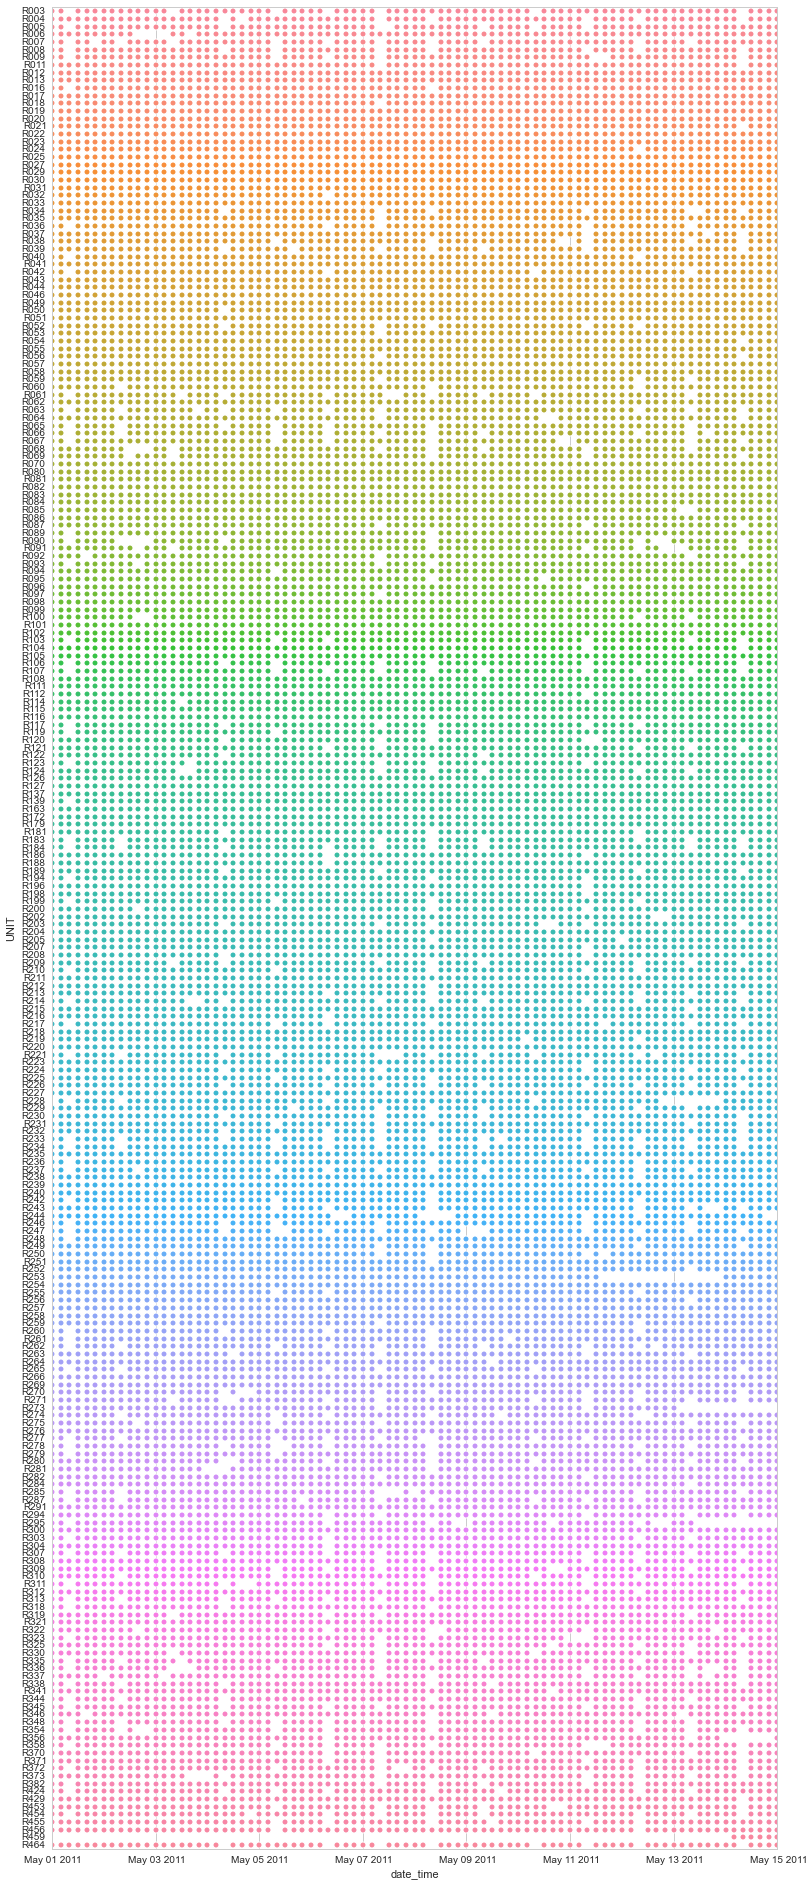

In [28]:
plt.figure(figsize=[13,33])
sns.stripplot(y='UNIT', x='date_time', data=df, size=6)
plt.xlim(df.date_time.min(), datetime(2011,5,15,0,0,0))